# Surface Code Decoder


### Single-step Surface Code Decoder, T = 1

#### Syndrome Graph


The `GraphDecoder(d,T)` class, located in `fitters.py`, constructs the graph corresponding to the possible syndrome measurements of a quantum error correction rotated surface code, runs minimum weight perfect matching (MWPM) on a subgraph of detected syndrome measurements to determine the most probable sequence of data qubit gate errors across time, and then calculates the net qubit gate error on the affected data qubits. Our surface code is structured as a square lattice of data qubits (represented by the square lattice vertices), each of which are surrounded by `X` and `Z` stabilizing ancilla qubits (represented by the faces of squares and semicircles) as shown in **Figure 1**. 

Each square and semicircle in **Figure 1** denotes an ancilla qubit which measures either an `X` (blue shading) or `Z` (red shading) error syndrome. These squares and semicircles represent **real** syndrome nodes. The floating circles in **Figure 1** denote **virtual** syndrome nodes: ancilla qubits that are not present in our finite rotated surface code. The presence of virtual syndrome nodes, or equivalently the finite truncated nature of the rotated surface code, is largely responsible for the code's non-zero logical error rate.

`GraphDecoder(d,T)` returns a rotated surface code decoder for a `d by d`  data qubit lattice with ancilla qubits repeatedly measured over `T` cycles in time. A graph connecting all types of syndrome nodes with edges representing data qubit and ancilla qubit errors is called a syndrome graph. The `Z` syndrome graph, in the case of `T = 1` and `d = 5`, is depicted in **Figure 1**.


<img src="img/syndrome_graph.jpg" alt="Figure 1"
	title="Figure 1" width="45%"/>
    <center> <b> Figure 1. </b> Again, lattice vertices denote data qubits, semicircles and squares denote real syndrome nodes, floating circles denote virtual syndrome nodes, and red shading implies Z, while blue shading implies X. Please also note the syndrome graph connects syndrome nodes with a purple colored edge, and each syndrome node is labelled in `(t,i,j)`notation.  </center>
    
    
We can construct the `Z` syndrome graph shown in **Figure 1** using `GraphDecoder(5,1)`. 

In [1]:
import sys
sys.path.insert(0, r'C:\Users\shrey\OneDrive\Documents\qec_surface_code')

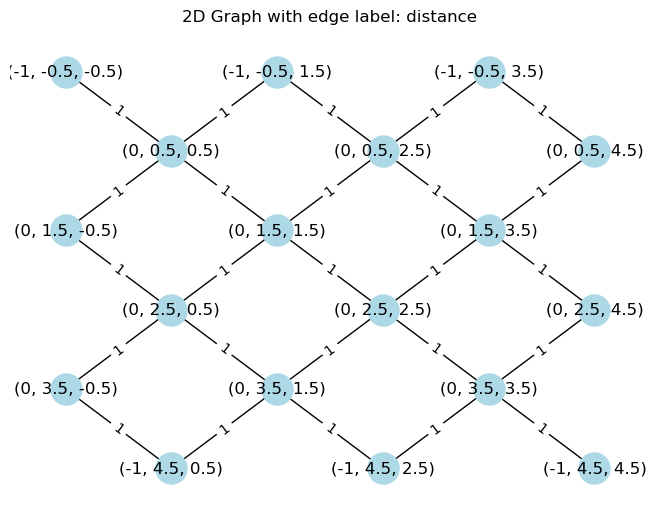

In [2]:
import sys
sys.path.insert(0, r'C:\Users\shrey\OneDrive\Documents\qec_surface_code')
from surface_code.fitters import GraphDecoder

decoder = GraphDecoder(5,1)
G = decoder.S['Z']
decoder.graph_2D(G,'distance')

Each edge of the above `Z` syndrome graph for `d = 5` and `T = 1` represents a possible `Z` error at a physical qubit at a lattice vertex, which is why there are `5 x 5` edges. Each node in the above graph is labelled by `(t,i,j)` where `i` represents the **row** of the syndrome, `j` the **column**, and `t` the **time**. These spatial-temporal indices are important because each syndrome node represents a possible ancilla measurement in the surface code quantum circuit at a different position and time. For example, in the case of the single-step surface code, `t = 0` for all **real** syndrome nodes as time indices only go from `0` to `T-1`. That said, since **virtual** syndrome measurements are by definition unavailable to the user, the **virtual** syndrome nodes always have `t = -1`. As an example, the edge between node `(0,0.5,0.5)` and `(0,1.5,1.5)` represents a `Z` error on the physical qubit at position `(1,1)` at time `t = 0`. 

Similarly, the `X` syndrome graph for `d = 5` and `T=1` is shown below.

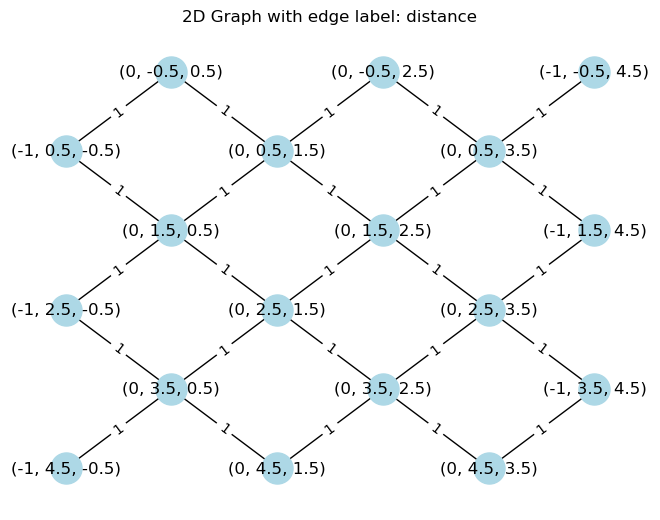

In [3]:
G = decoder.S['X']
decoder.graph_2D(G,'distance')

#### Most Probable Error Sets

The input to surface code decoding is a set of **real** syndrome node measurements. Sticking with the example of `d = 5` and `T=1`, an example set of syndrome node measurements may include `Z` stabilizer measurments in the ancilla qubits at `[(0,0.5,0.5),(0,1.5,1.5),(0,1.5,3.5), (0,3.5,3.5)]` and `X` stabilizer measurements at `[(0,1.5,0.5),(0,0.5,1.5)]`. This case is shown in **Figure 2**. 

The goal of decoding is to now find the most probable set of data qubit flips that resulted in the ancilla qubit sydnrome measurements stated above. A set of data qubit flips is found by specifying a set of edges connecting detected syndromes on their respective syndrome graphs. 

Any set of `X` and `Z` errors on data qubits can be represented by collections of edges on the `X` and `Z` syndrome graphs. Of course, since data qubit flip errors only activate adjoining syndrome nodes, only some collections of edges are even allowed given a specific syndrome measurement set. For example, if an `X` error occurs on data qubit `(0,1,1)`, the syndrome nodes `[(0,0.5,1.5),(0,1.5,0.5)]` will be triggered. 

Of course, chains of adjacent data qubit errors can cancel out each other at common syndrome nodes. So, as a rule of thumb, a chain of `X` (`Z`) errors will only trigger the `X` (`Z`) syndrome nodes at the ends of the chain. Finally, if both an `X` and `Z` error occurs at the same data qubit, then that combined error will be labeled a `Y` error as per Pauli matrix convention.

In general, multiple error sets can lead to a set of observed syndromes. Out of these, the error set `E` with fewest errors is the most probable. Each error set `E` is also comprised of chains of errors, as discussed above. Suppose `p(E)` represents the probability of an error set `E`, then 

<img src="https://latex.codecogs.com/gif.latex?p(E) = (1-p)^n \prod_{e \in \text{chain}(E)} \left(\frac{p}{1-p}\right)^{|e|}" /> 

where `n = d x d` denotes the number of data qubits.

To maximize `p(E)`, it suffices to maximize a proportional function

<img src="https://latex.codecogs.com/gif.latex?p(E) \propto \prod_{e \in \text{chain}(E)} \left(\frac{p}{1-p}\right)^{|e|}" /> 
<img src="https://latex.codecogs.com/gif.latex?p(E) \sim \sum_{e \in \text{chain}(E)} |e|\ln\left(\frac{p}{1-p}\right)" /> 
<img src="https://latex.codecogs.com/gif.latex?p(E) \propto - \sum_{e \in \text{chain}(E)} |e|" /> 
where `|e|` denotes the number of edges (number of errors) in the error chain `e` and where `p/(1-p) << 1`.

In order to maximise the likelihood of a prospective error `E`, we should find a set of error chains (edges) that connects the syndrome nodes in pairs (a perfect matching in graph theory) with minimal weight. Finding minimal-weight perfect matchings (MWPM) is a well-known combinatorial problem, solved using the Blossom algorithm [[1]](https://arxiv.org/abs/1709.02154). The matching algorithm is run on an `error_graph` comprised of the detected syndrome nodes, virtual syndrome nodes, and edges weighted by `-|e|`: the length of the shortest error chain between the syndrome nodes as determined by the syndrome graph. 

**Figure 2** shows the most probable prospective error set `E` predicted by a MWPM algorithm for the example set of syndromes specified above.


<img src="img/error_set.jpg" alt="Figure 2"
	title="Figure 2" width="45%"/>
    <center> <b> Figure 2. </b>  Detected syndrome nodes are shaded in yellow, and a most probable correspnoding error set is depicted in green. </center>
    

`GraphDecoder(5,1)` can be used to produce the most probable error set shown in **Figure 2** as demonstrated below.

In [4]:
syndromes_x = [(0,1.5,.5),(0,.5,1.5)]
error_graph_x, paths_x = decoder.make_error_graph(syndromes_x,'X')
matching_graph_x = decoder.matching_graph(error_graph_x,'X')
matches_x = decoder.matching(matching_graph_x,'X')
flips_x = decoder.calculate_qubit_flips(matches_x, paths_x,'X')

syndromes_z = [(0,0.5,0.5),(0,1.5,1.5),(0,1.5,3.5), (0,3.5,3.5)]
error_graph_z, paths_z = decoder.make_error_graph(syndromes_z,'Z')
matching_graph_z = decoder.matching_graph(error_graph_z,'Z')
matches_z = decoder.matching(matching_graph_z,'Z')
flips_z = decoder.calculate_qubit_flips(matches_z, paths_z,'Z')

flips = decoder.net_qubit_flips(flips_x, flips_z)

print("Result\n")
for qubit, flip in flips.items():
    print("Physical Qubit: " + str(qubit) + "\nFlip: " + "\n" + str(flip) +"\n")


Result

Physical Qubit: (1.0, 1.0)
Flip: 
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

Physical Qubit: (2.0, 3.0)
Flip: 
[[ 1  0]
 [ 0 -1]]

Physical Qubit: (3.0, 3.0)
Flip: 
[[ 1  0]
 [ 0 -1]]



Recalling Pauli matrix notation, the above result depicts a net `Y` error on the `(1,1)` data qubit, and net `Z` errors on the `(2,3)` and `(3,3)` data qubits. This result is consistent with what is shown in **Figure 2**. 

**Note:** the final results depict the net gate error on each physical qubit at the end of the quantum circuit, and so there is no time index. 

#### Degeneracy Weighting 

When there are multiple shortest paths between syndrome nodes on a syndrome graph, the associated error chains are thought to be more probable. This degeneracy in some error chain `e` is denoted as `Ω(e)`, which in turn affects the probability of the entire error set `E` in which `e` is included. 

<img src="https://latex.codecogs.com/gif.latex?p(E) \propto (1-p)^n \prod_{e \in \text{chain}(E)} \Omega(e)\left(\frac{p}{1-p}\right)^{|e|}" /> 
<img src="https://latex.codecogs.com/gif.latex?p(E) \propto - \sum_{e \in \text{chain}(E)}\left\{ |e| - \Omega(e)\left(\frac{p}{1-p}\right)^{|e|}\right\}" /> 

The aformentioned `error_graph` now edge weights (formerly `-|e|`) increased by degeneracy counts as shown above. A more detailed derivation can be found in reference [1](https://arxiv.org/abs/1709.02154).

As shown below, an `error_graph` under degeneracy considerations has adjusted edge weights.


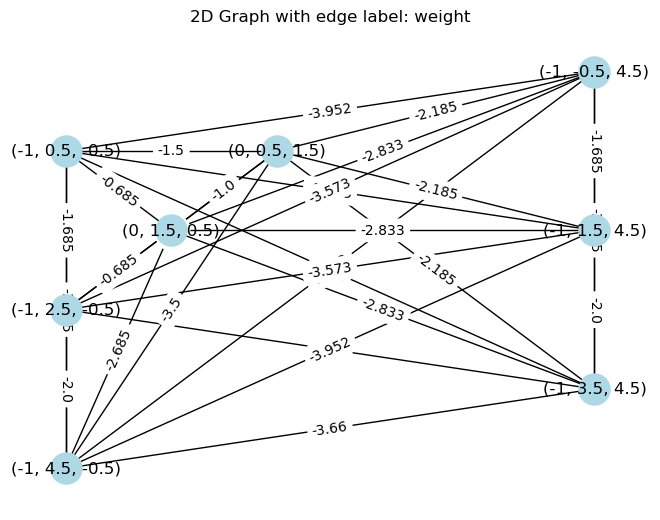

In [5]:
decoder = GraphDecoder(5,1)
p = 0.1
syndromes_x = [(0,1.5,.5),(0,.5,1.5)]
error_graph_x, paths_x = decoder.make_error_graph(syndromes_x,'X',err_prob=p)
decoder.graph_2D(error_graph_x, "weight")

In [6]:
matching_graph_x = decoder.matching_graph(error_graph_x,'X')
matches_x = decoder.matching(matching_graph_x,'X')
flips_x = decoder.calculate_qubit_flips(matches_x, paths_x,'X')

syndromes_z = [(0,0.5,0.5),(0,1.5,1.5),(0,1.5,3.5), (0,3.5,3.5)]
error_graph_z, paths_z = decoder.make_error_graph(syndromes_z,'Z')
matching_graph_z = decoder.matching_graph(error_graph_z,'Z')
matches_z = decoder.matching(matching_graph_z,'Z')
flips_z = decoder.calculate_qubit_flips(matches_z, paths_z,'Z')

flips = decoder.net_qubit_flips(flips_x, flips_z)

print("Result\n")
for qubit, flip in flips.items():
    print("Physical Qubit: " + str(qubit) + "\nFlip: " + "\n" + str(flip) +"\n")


Result

Physical Qubit: (1.0, 1.0)
Flip: 
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

Physical Qubit: (2.0, 3.0)
Flip: 
[[ 1  0]
 [ 0 -1]]

Physical Qubit: (3.0, 3.0)
Flip: 
[[ 1  0]
 [ 0 -1]]



### Multi-step Surface Code Decoder, T > 1

In the case of `T > 1`, the syndrome graph will be propelled into three dimensions, including time. Edges between syndrome nodes at the same time index in this `3D` syndrome graph still correspond to data qubit errors, while edges between the **same** syndrome node at adjecent time indices (these are the only edges that exist between syndrome nodes of different time indices [[2]](http://arxiv.org/abs/0905.0531v1)) correspond to ancilla qubit errors, also known as syndrome measurement errors. 

Consider a `Z` syndrome detected at syndrome node `(0,0.5,0.5)` and another `Z` syndrome detected at node `(1,0.5,0.5)`. The most probable propsective error would be that the ancilla qubit measuring the syndrome node at location `(0.5,0.5)` incurred a measurement error at time `t = 0`. Then, at time `t=1`, that same ancilla qubit detected no error in nearby data qubits and measured another `Z` syndrome simply because its state changed between time step `t = 0` and time step `t = 1`. This is reminiscent of the bitwise OR notation found in repitition code quantum circuits.

The associated syndrome graphs of `GraphDecoder(d=5,T=3)` can be beautifully visualized using the `GraphDecoder.graph_2D` and `GraphDecoder.graph_3D` functions shown below. It should be noted that outside of a `jupyter` notebook **these 3D graphs are rotatable**. 

You can see an example schematic from the following paper:

<p align="center">
<img width="700" alt="Screen Shot 2020-07-01 at 3 54 32 PM" src="https://user-images.githubusercontent.com/293681/86285739-286d1900-bbb3-11ea-957e-c38ad1563498.png">
</p>

* Wang, D. S., Fowler, A. G., Stephens, A. M. & Hollenberg, L. C. L. Threshold error rates for the toric and surface codes. arXiv:0905.0531 [quant-ph] (2009).


ValueError: too many values to unpack (expected 3)

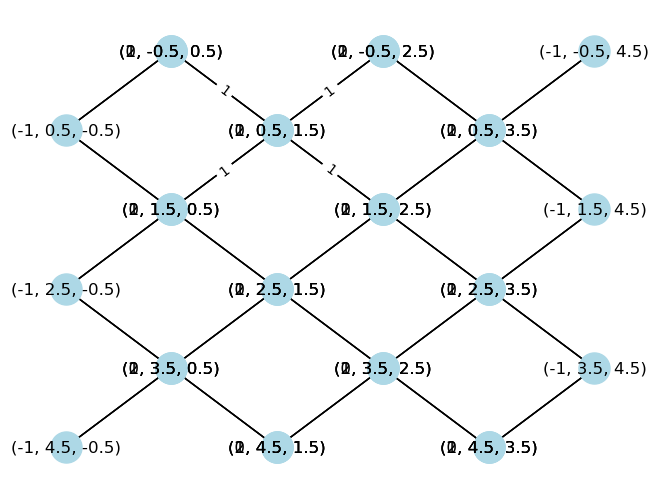

In [7]:
decoder = GraphDecoder(5,3)
G = decoder.S['X']
decoder.graph_2D(G,'distance')
decoder.graph_3D(G,'distance')

The syndrome nodes in pink, orange, and yellow represent **real** syndrome nodes from times `t = 0,1,2` respectively, as denoted by their labels. The syndrome nodes in dark blue denote **virtual** syndrome nodes, as denoted by their `t = -1` time index. Below, a set of example syndrome node measurements are used to find the most probable error set on a Surface Code with `d = 5` and `T = 3`.

In [8]:
syndromes_x = [(0,1.5,.5),(0,.5,1.5),(1,1.5,.5),(1,.5,1.5),(2,1.5,.5),(2,.5,1.5)]
error_graph_x, paths_x = decoder.make_error_graph(syndromes_x,'X')
matching_graph_x = decoder.matching_graph(error_graph_x,'X')
matches_x = decoder.matching(matching_graph_x,'X')
flips_x = decoder.calculate_qubit_flips(matches_x, paths_x,'X')

syndromes_z = [(0,0.5,0.5),(0,1.5,1.5),(0,1.5,3.5), (0,3.5,3.5),(2,1.5,3.5), (2,3.5,3.5)]
error_graph_z, paths_z = decoder.make_error_graph(syndromes_z,'Z')
matching_graph_z = decoder.matching_graph(error_graph_z,'Z')
matches_z = decoder.matching(matching_graph_z,'Z')
flips_z = decoder.calculate_qubit_flips(matches_z, paths_z,'Z')

flips = decoder.net_qubit_flips(flips_x, flips_z)

print("Result\n")
for qubit, flip in flips.items():
    print("Physical Qubit: " + str(qubit) + "\nFlip: " + "\n" + str(flip) +"\n")


Result

Physical Qubit: (1.0, 1.0)
Flip: 
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]



Here is another longer example with `d = 9` and `T = 3` with more colorful graphs detailing each step of the decoding process. This is an optional example for the curious reader. 

ValueError: too many values to unpack (expected 3)

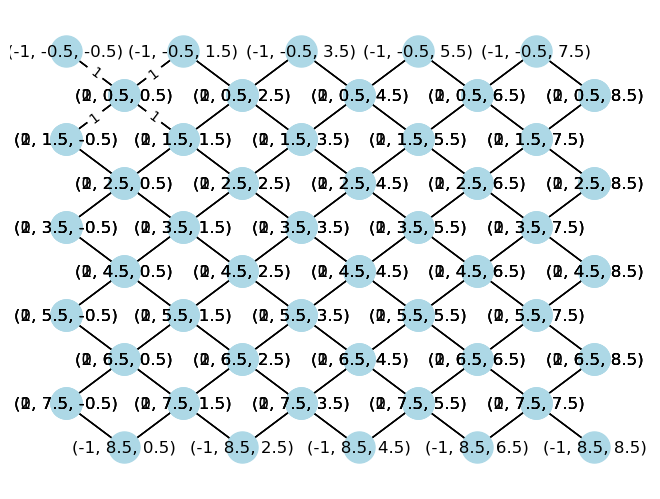

In [9]:
decoder = GraphDecoder(9,3)
G = decoder.S['Z']
decoder.graph_2D(G,'distance')
decoder.graph_3D(G,'distance')

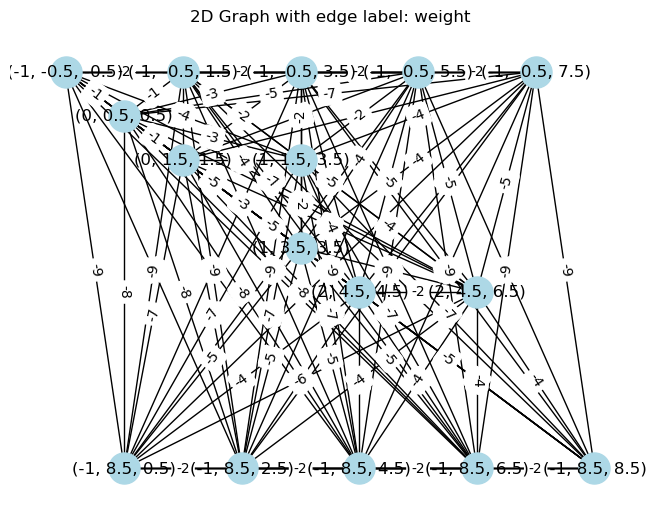

<Figure size 2000x1400 with 0 Axes>

In [10]:
node_set = [(0,0.5,0.5),(0,1.5,1.5),(1,1.5,3.5),(1,3.5,3.5),(2,4.5,4.5),(2,4.5,6.5)]
error_graph, paths = decoder.make_error_graph(node_set,'Z')
decoder.graph_2D(error_graph,'weight')#note that some edges overlap
decoder.graph_3D(error_graph,'weight')#note that some edges overlap

ValueError: too many values to unpack (expected 3)

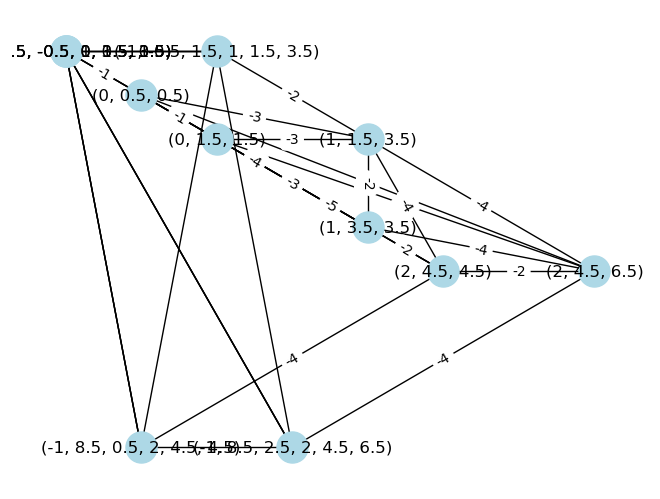

In [11]:
matching_graph = decoder.matching_graph(error_graph,'Z')
decoder.graph_2D(matching_graph,'weight')
decoder.graph_3D(matching_graph,'weight')

In [12]:
g = decoder.matching(matching_graph,'Z')
for e in g:
    print(e)

((0, 0.5, 0.5), (0, 1.5, 1.5))
((1, 1.5, 3.5), (1, 3.5, 3.5))
((2, 4.5, 6.5), (2, 4.5, 4.5))


In [13]:
matching_graph = decoder.matching_graph(error_graph,'Z')
matches = decoder.matching(matching_graph,'Z')
flips_z = decoder.calculate_qubit_flips(matches, paths,'Z')

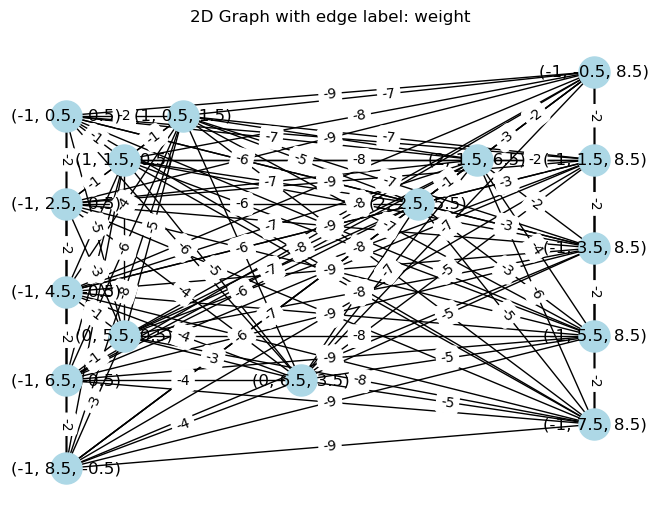

<Figure size 2000x1400 with 0 Axes>

In [14]:
node_set = [(1,1.5,0.5),(1,0.5,1.5),(2,1.5,6.5),(2,2.5,5.5),(0,5.5,.5),(0,6.5,3.5)]
error_graph, paths = decoder.make_error_graph(node_set,'X')
decoder.graph_2D(error_graph,'weight')#note that some edges overlap
decoder.graph_3D(error_graph,'weight')

ValueError: too many values to unpack (expected 3)

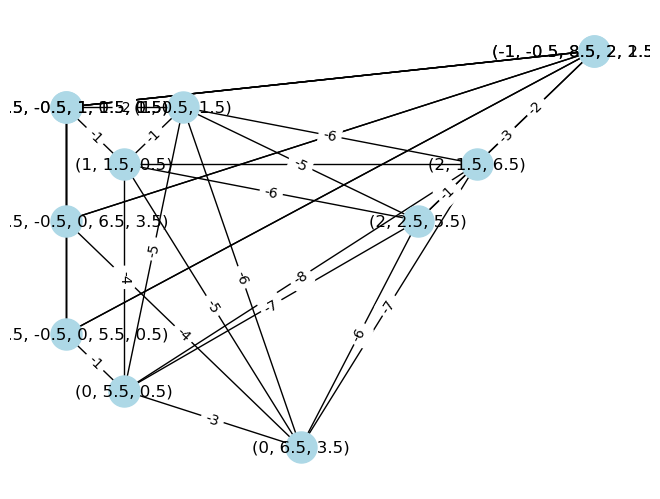

In [15]:
matching_graph = decoder.matching_graph(error_graph,'X')
decoder.graph_2D(matching_graph,'weight')
decoder.graph_3D(matching_graph,'weight')

In [ ]:
g = decoder.matching(matching_graph,'X')
for e in g:
    print(e)

In [17]:
matching_graph = decoder.matching_graph(error_graph,'X')
matches = decoder.matching(matching_graph,'X')
flips_x = decoder.calculate_qubit_flips(matches, paths,'X')

In [18]:
flips = decoder.net_qubit_flips(flips_x, flips_z)
print("Result\n")
for qubit, flip in flips.items():
    print("Physical Qubit: " + str(qubit) + "\nFlip: " + "\n" + str(flip) +"\n")

Result

Physical Qubit: (2.0, 6.0)
Flip: 
[[0 1]
 [1 0]]

Physical Qubit: (5.0, 1.0)
Flip: 
[[0 1]
 [1 0]]

Physical Qubit: (5.0, 2.0)
Flip: 
[[0 1]
 [1 0]]

Physical Qubit: (6.0, 3.0)
Flip: 
[[0 1]
 [1 0]]

Physical Qubit: (1.0, 1.0)
Flip: 
[[ 0  1]
 [-1  0]]

Physical Qubit: (2.0, 3.0)
Flip: 
[[ 1  0]
 [ 0 -1]]

Physical Qubit: (3.0, 3.0)
Flip: 
[[ 1  0]
 [ 0 -1]]

Physical Qubit: (4.0, 5.0)
Flip: 
[[ 1  0]
 [ 0 -1]]

Physical Qubit: (4.0, 6.0)
Flip: 
[[ 1  0]
 [ 0 -1]]



### Simulated Syndrome Graph

It is important to note that by default `GraphDecoder(d,T,simulation=False)` populates `X`and `Z`syndrome graphs using graph traversal of nearest neighbors. However, upon enabling the `simulated`attribute, `GraphDecoder(d,T,simulation=True)` generates `X`and `Z`syndrome  graphs using simulated Surface Code quantum circuits. 

Below, a `d = 3`and `T = 2`surface code example is detailed. Please be wary of the long time it may take to generate a syndrome graph using simulation. 

In [ ]:
decoder = GraphDecoder(3,2, simulation=True)
G = decoder.S['Z']
decoder.graph_3D(G,'distance')

In [ ]:
G = decoder.S['X']
decoder.graph_3D(G,'distance')

Thanks for reading!!